In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from einops import repeat, rearrange

## Data

In [2]:
img = data.astronaut()

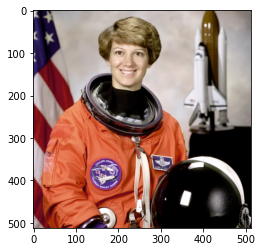

In [3]:
fig, ax = plt.subplots()

ax.imshow(img)

plt.show()

### Reshape

In [4]:
def squeeze(x, factor=2):
    assert x.ndim == 4
    b, c, h, w = x.shape
    
    assert h % factor == 0
    assert w % factor == 0
    
    x = x.view(b, c, h // factor, factor, w // factor, factor)
    x = x.permute(0, 3, 5, 1, 2, 4).contiguous()
    x = x.view(b, c * factor ** 2, h // factor, w // factor)
    
    return x

def unsqueeze(x, factor=2):
    assert x.ndim == 4
    b, c, h, w = x.shape
    
    x = x.view(b, c // factor ** 2, factor, factor, h, w)
    x = x.view(b, factor, factor, c // factor ** 2, h, w)
    x = x.permute(0, 3, 4, 1, 5, 2).contiguous()
    x = x.view(b, c // factor ** 2, h * factor, w * factor)
    return x

In [5]:
img.dtype

dtype('uint8')

In [6]:
x = repeat(img, "... -> 1 ...")
x = rearrange(x, "B H W C -> B C H W")
x = torch.Tensor(x)
img_squeeze = squeeze(x)


x_orig = unsqueeze(img_squeeze)

img_squeeze = rearrange(img_squeeze, "B C H W -> B H W C").numpy().astype(np.uint8)


np.testing.assert_array_equal(x, x_orig)

In [7]:
img_squeeze.min(), img_squeeze.max()

(0, 255)

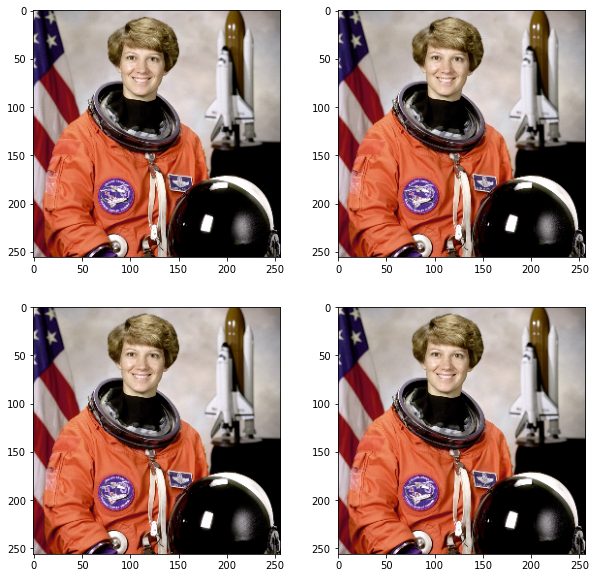

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., :3])
axs[0, 1].imshow(img_squeeze[0, ..., 3:6])
axs[1, 0].imshow(img_squeeze[0, ..., 6:9])
axs[1, 1].imshow(img_squeeze[0, ..., 9:12])
plt.show()

## Squeeze (Orthogonal)

In [9]:
from scipy.stats import ortho_group
kernel = []
for _ in range(3):
    ikernel = ortho_group.rvs(4)
    ikernel = np.reshape(ikernel, (4, 1, 2, 2))
    kernel.append(ikernel)
    
kernel = np.concatenate(kernel, axis=0)
# kernel = torch.Tensor(kernel)

In [13]:
kernels = []
for _ in range(3):
    w = torch.empty(4, 4)
    torch.nn.init.orthogonal_(w)
    kernels.append(w.reshape(4, 1, 2, 2))
kernel = torch.cat(kernels, dim=0)

In [14]:
img_squeeze = F.conv2d(x, kernel, bias=None, stride=2, groups=3)
x_ori = F.conv_transpose2d(img_squeeze, kernel, bias=None, stride=2, groups=3)

img_squeeze = rearrange(img_squeeze, "B C H W -> B H W C").numpy().astype(np.uint8)

np.testing.assert_array_equal(x, x_orig)

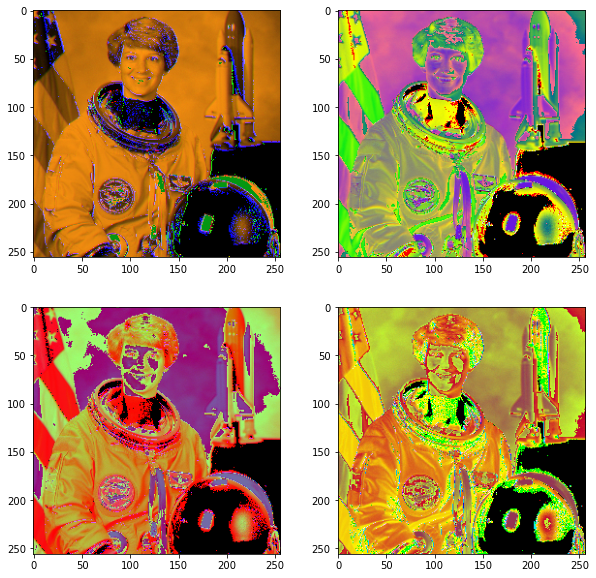

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., :3])
axs[0, 1].imshow(img_squeeze[0, ..., 3:6])
axs[1, 0].imshow(img_squeeze[0, ..., 6:9])
axs[1, 1].imshow(img_squeeze[0, ..., 9:12])
plt.show()

## iRev

In [16]:
kernel = torch.zeros(4, 1, 2, 2)

kernel[0, 0, 0, 0] = 1
kernel[1, 0, 0, 1] = 1
kernel[2, 0, 1, 0] = 1
kernel[3, 0, 1, 1] = 1

kernel = torch.cat([kernel] * 3, 0)

In [17]:
img_squeeze = F.conv2d(x, kernel, bias=None, stride=2, groups=3)
x_ori = F.conv_transpose2d(img_squeeze, kernel, bias=None, stride=2, groups=3)

img_squeeze = rearrange(img_squeeze, "B C H W -> B H W C").numpy().astype(np.uint8)

np.testing.assert_array_equal(x, x_orig)

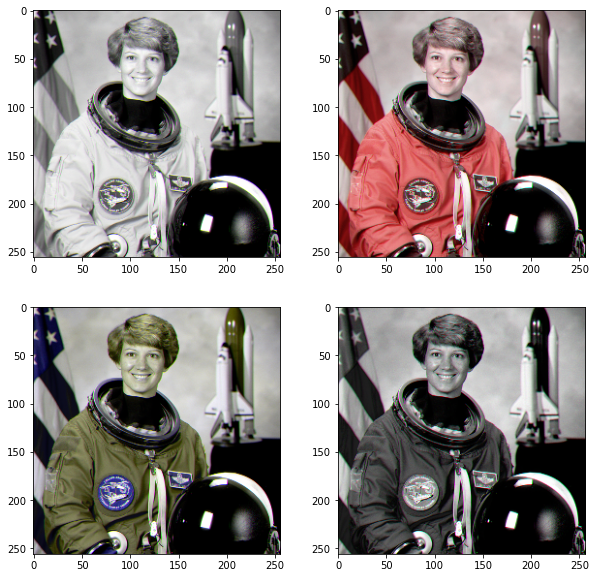

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., :3])
axs[0, 1].imshow(img_squeeze[0, ..., 3:6])
axs[1, 0].imshow(img_squeeze[0, ..., 6:9])
axs[1, 1].imshow(img_squeeze[0, ..., 9:12])
plt.show()

## Wavelet (Ortho)

In [27]:
import pywt

In [39]:
original = pywt.data.camera()

In [35]:
pywt.data.nino().shape

(264,)

* pwt - [python package]https://pywavelets.readthedocs.io/en/latest/index.html#main-features()
* Wavelet Families - [Webpage](http://wavelets.pybytes.com/wavelet/haar/)

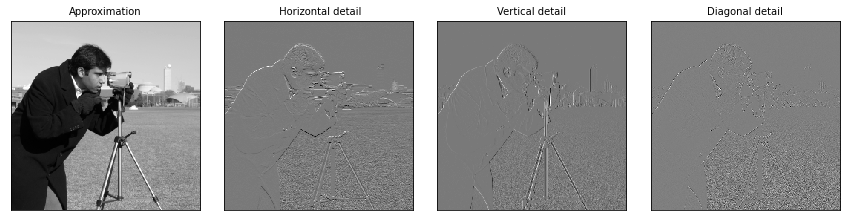

In [44]:
# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [45]:
original_inv = pywt.idwt2(coeffs2, 'haar')

In [50]:
data.grass().shape

(512, 512)

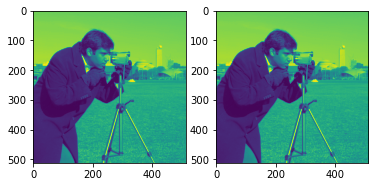

In [48]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(original)
ax[1].imshow(original_inv)

plt.show()

In [126]:
b, h, w, c = x.shape

kernel = torch.ones((4, 1, 2, 2))
kernel[1, 0, 0, 1] = -1
kernel[1, 0, 1, 1] = -1

kernel[2, 0, 1, 0] = -1
kernel[2, 0, 1, 1] = -1

kernel[3, 0, 1, 0] = -1
kernel[3, 0, 0, 1] = -1
kernel *= 0.5

print(kernel.shape)


torch.Size([4, 1, 2, 2])


In [127]:
kernel = torch.cat([kernel] * 3, 0)
# kernel = repeat(kernel, "B C H W -> B ("
kernel.shape

torch.Size([12, 1, 2, 2])

In [128]:
import torch.nn as nn

In [129]:
from einops import repeat

In [138]:
img_squeeze = F.conv2d(x, kernel, bias=None, stride=2, groups=3)
# img_squeeze = conv_layer(x)
x_ori = F.conv_transpose2d(img_squeeze, kernel, bias=None, stride=2, groups=3)

img_squeeze = rearrange(img_squeeze, "B C H W -> B H W C").detach().numpy().astype(np.uint8)

np.testing.assert_array_equal(x, x_orig)

In [140]:
img_squeeze.min(), img_squeeze.max(), img_squeeze.shape

(0, 255, (1, 256, 256, 12))

In [141]:
from sklearn.preprocessing import MinMaxScaler

img_squeeze = MinMaxScaler((0., 255.)).fit_transform(img_squeeze.ravel()[:, None]).ravel()
img_squeeze = img_squeeze.reshape((1, 256, 256, 12))

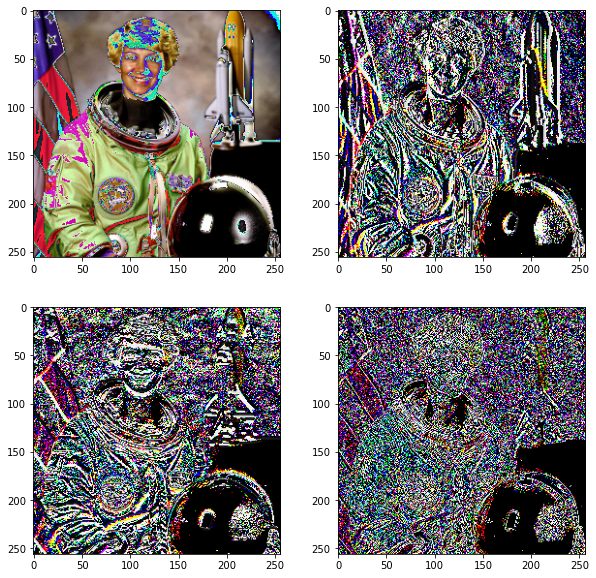

In [143]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., 0::4].astype(np.uint8))
axs[0, 1].imshow(img_squeeze[0, ..., 1::4].astype(np.uint8))
axs[1, 0].imshow(img_squeeze[0, ..., 2::4].astype(np.uint8))
axs[1, 1].imshow(img_squeeze[0, ..., 3::4].astype(np.uint8))
plt.show()

### Wavelet (Signals)

In [66]:
b, h, w, c = x.shape

kernel = torch.ones((4, 1, 2, 2))
kernel[1, 0, 0, 1] = -1
kernel[1, 0, 1, 1] = -1

kernel[2, 0, 1, 0] = -1
kernel[2, 0, 1, 1] = -1

kernel[3, 0, 1, 0] = -1
kernel[3, 0, 0, 1] = -1


kernel = torch.cat([kernel] * 3, 0)
kernel.shape

torch.Size([12, 1, 2, 2])

In [101]:
# kernel *= 0.5

rebalance = 1.0
fac_fwd = 0.5 * rebalance
jac_fwd = (np.log(16.) + 4 * np.log(fac_fwd)) / 4.

fac_rev = 0.5 / rebalance
jac_rev = (np.log(16.) + 4 * np.log(fac_rev)) / 4.

In [102]:
jac_fwd, jac_rev

(0.0, 0.0)

In [103]:
img_squeeze = F.conv2d(x, kernel, bias=None, stride=2, groups=3)
x_ori = F.conv_transpose2d(img_squeeze, kernel, bias=None, stride=2, groups=3)
x_ori *= fac_fwd

img_squeeze = rearrange(img_squeeze, "B C H W -> B H W C").numpy()
img_squeeze *= fac_rev
img_squeeze = img_squeeze.astype(np.uint8)

np.testing.assert_array_equal(x, x_orig)

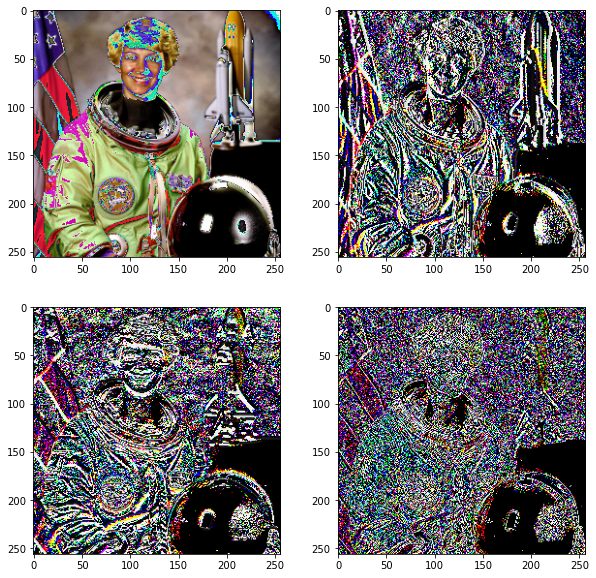

In [104]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., 0::4])
axs[0, 1].imshow(img_squeeze[0, ..., 1::4])
axs[1, 0].imshow(img_squeeze[0, ..., 2::4])
axs[1, 1].imshow(img_squeeze[0, ..., 3::4])
plt.show()

## Kernels

* HouseHolder Matrix
* Cayley Matrix
* Matrix Exponential
* Bjork
* Givens
* Random Rotations
* Haar